Before we get into any code, lets take a look first at what the goal is here, then break it down a little bit to get us onto the right path without wasting too much time. 

That goal is to: take stock data and form it into a linerider track.

Things I'd like to investigate to complete this goal (both conceptual topics and objective pieces of knowledge to look up if necessary):
1. How is a linerider track data stored? How do we manipulate a linerider track after saving it? How do we save the file to our computer?
2. How is stock data exported from the internet? How is this data given to us? How do we manipulate this data into the format that linerider uses to create their tracks?
3. How do we improve it?

In [ ]:
# Required imports
import json
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 6.4 MB 30.5 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## How is a linerider track stored?

I've created a sample linerider track which contains just a rider and a line underneath him to see what this file looks like. To our luck, it's a simple JSON file with a very straightforward format

```
{
    "label": "sample_track",
    "creator": "Blake Sekelsky",
    "description": "",
    "duration": 1500,
    "version": "6.2",
    "audio": null,
    "startPosition": {
        "x": 0,
        "y": 0
    },
    "riders": [
        {
            "startPosition": {
                "x": 0,
                "y": -10
            },
            "startVelocity": {
                "x": 0.4,
                "y": 0
            },
            "remountable": 1
        }
    ],
    "layers": [
        {
            "id": 0,
            "name": "Base Layer",
            "visible": true,
            "editable": true
        }
    ],
    "lines": [
        {
            "id": 1,
            "type": 0,
            "x1": -100.0,
            "y1": -50.0,
            "x2": 100.0,
            "y2": 50.0,
            "flipped": false,
            "leftExtended": false,
            "rightExtended": false
        }
    ]
}
```



```
"lines": [
    {
        "id": 1,
        "type": 0,
        "x1": -100.0,
        "y1": -50.0,
        "x2": 100.0,
        "y2": 50.0,
        "flipped": false,
        "leftExtended": false,
        "rightExtended": false
    }
]
```

Manipulating the ```lines``` attributes, you can edit the points of the line, you can also change the types of the lines. I'm using ```type=1``` in my final version because that is the type with forward speed. But you can make this better by exploring other types as well.

```
"startPosition": {
        "x": 0,
        "y": 0
}
```
Here we can change the origin coordinates of the the screen

```
"riders": [
    {
        "startPosition": {
            "x": 0,
            "y": -10
        },
        "startVelocity": {
            "x": 0.4,
            "y": 0
        },
        "remountable": 1
    }
]
```
This is where you can change the origin coordinates and velocity of the rider(s), which will come in handy since stock prices will start out differently for each track

## Building our own gamefile

The other options will be looked through as needed, but these look to be the meat of what we needed to figure out to manipulate new lines. Let's try to create our own track now we know how it's created on their end. 

In [ ]:
# Staging everything for the JSON object to be built at the end

label = 'sample_map'
creator = 'stockrider.py'
description = ''
duration = 1500
version = '6.2'
audio = None

startPosition = {
  "x": 0,
  "y": 0
}

# Rider origin coordinates
riders = [
  {
    "startPosition": {
        "x": 0,
        "y": -10
    },
    "startVelocity": {
        "x": 0.4,
        "y": 0
    },
    "remountable": 1
  }
]

layers = [
  {
    "id": 0,
    "name": "Base Layer",
    "visible": True,
    "editable": False
  }
]
lines = []
track = {
    "label": label,
    "creator": creator,
    "description": description,
    "version": version,
    "audio": audio,
    "startPosition": startPosition,
    "riders": riders,
    "layers": layers,
    "lines": lines
}

with open('stockrider.track.json', 'w') as outfile:
  json.dump(track, outfile)

If you go to your google colab files, you can take ```stockrider.track.json``` over to https://linerider.com, Load the track, and see that it successfully has taken our gamefile and loads our rider and line underneath. Now that we know that this method will work for us, we can define building & saving the track with a function ```save_track```

In [ ]:
def save_track(label=label, 
               creator=creator, 
               description=description, 
               duration=duration, 
               version=version, 
               audio=audio, 
               startPosition=startPosition, 
               riders=riders, 
               layers=layers, 
               lines=lines, 
               filename='stockrider.track.json'):
    track = {
    "label": label,
    "creator": creator,
    "description": description,
    "version": version,
    "audio": audio,
    "startPosition": startPosition,
    "riders": riders,
    "layers": layers,
    "lines": lines
    }

    with open(filename, 'w') as outfile:
      json.dump(track, outfile)


In [ ]:
# So now if we want to test out our function, lets run it with default params but specify a new filename then test it on linerider.
save_track(filename='mytrack.track.json')

## Manipulating lines

So now that we have our helper function working, lets dissect our ```lines``` object a little bit more and figure out how we can get some sample data into our linerider track.

In [ ]:
lines # A refresher on the structure

[{'flipped': False,
  'id': 1,
  'leftExtended': False,
  'rightExtended': False,
  'type': 0,
  'x1': -100.0,
  'x2': 100.0,
  'y1': -50.0,
  'y2': 50.0}]

Let's generate another line that connects to ours following the same format

In [ ]:
test_lines = [
  {
    'flipped': False,
    'id': 1,
    'leftExtended': False,
    'rightExtended': False,
    'type': 0, # we can leave this at 0, but we will be changing this to 1 to rightwards acceleration once we pull in more data
    'x1': -100.0,
    'x2': 100.0,
    'y1': -50.0,
    'y2': 50.0
  },
  {
    'flipped': False,
    'id': 2,
    'leftExtended': False,
    'rightExtended': False,
    'type': 0,
    'x1': 100.0,
    'x2': 500.0,
    'y1': 50.0,
    'y2': 450.0
  }
]

save_track(lines=test_lines)

The output we get, both lines are displayed correctly and we can continue further with importing of more data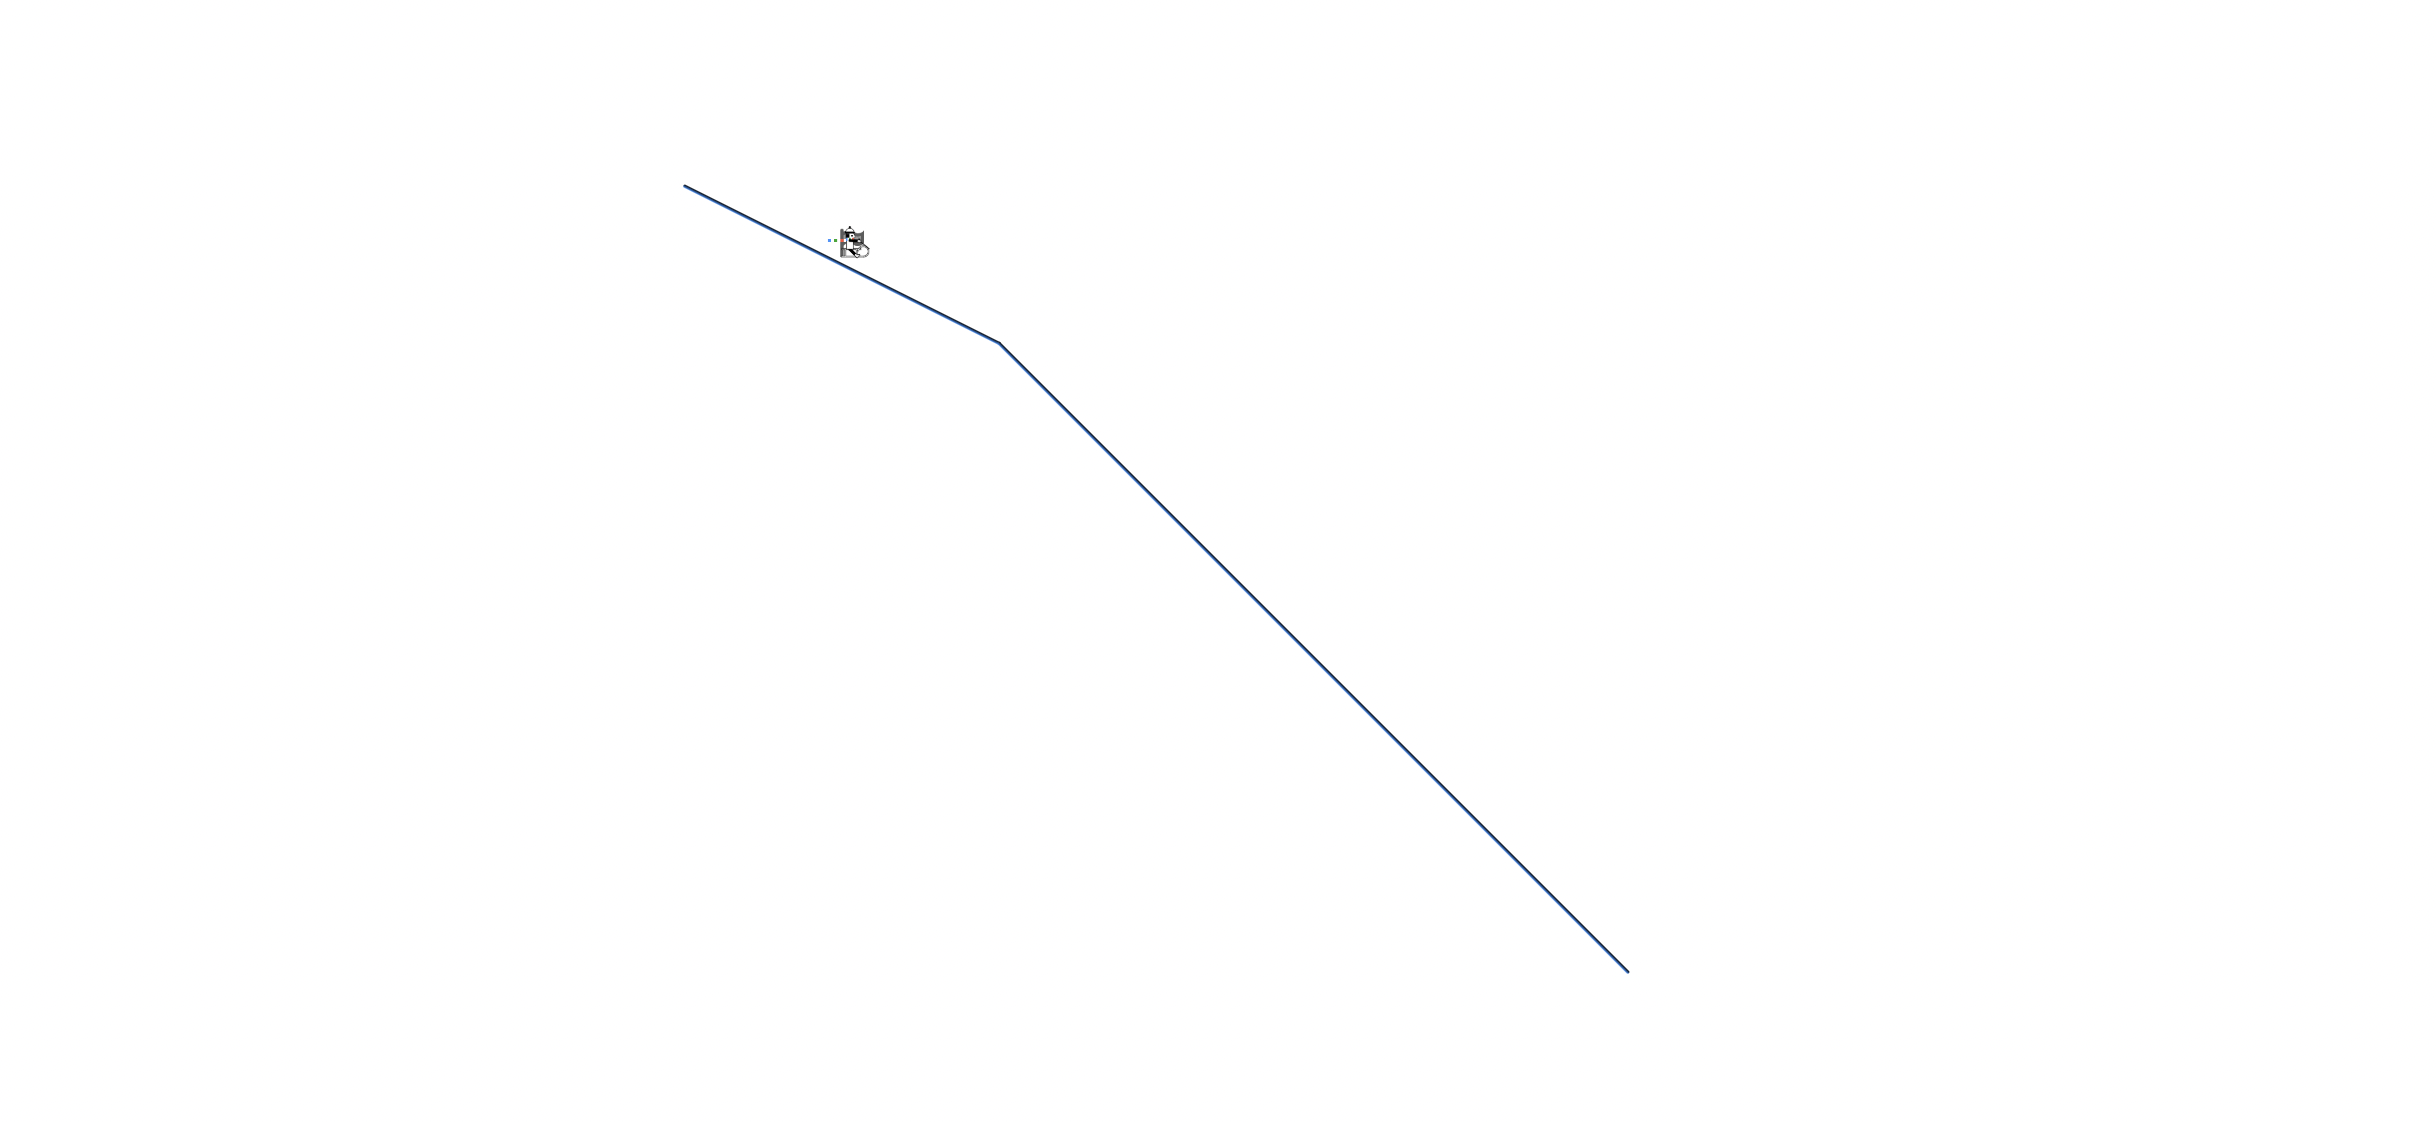

## Importing stock price data

But before we get ahead of ourselves and start writing functions, take a step back and think about the data that we want to include in our track. 

1. We want to graph the **daily price** of a stock. No matter how many days we put on our track, we will want a constant increment across each day, so we may want to include `x_inc` so we can adjust how long each line is horizontally. 

2. Another thing to look at is that our `y` values. 
  * Firstly, we are going to want a top and bottom(`y1`, `y2`) which could be either the Open/Close price, or the High/Low price which we will get next. 
  * Secondly, the scale that linerider uses on their tracks is a larger range(-inf, inf) than equity prices are. So we may want to include `y_scale` so we can adjust a multiplier of the price to an inflated value making the track less flat to play on.
  * We could standardize them to a max value inside of linerider, but I think that might make the results less fun/ridiculous so I won't. 
  
3. Another thing to note is that linerider is using a coordinate system that is flipped over the x-axis, so if you want to draw lines upwards go farther negative from 0.


In [ ]:
# Firstly, lets take a look at some stock data, and what we need to do to get it into the form we need.
data = yf.download('amd', '2021-06-01', '2022-05-05')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-01,81.010002,82.910004,80.660004,80.809998,80.809998,43433000
2021-06-02,81.000000,82.599998,80.660004,81.970001,81.970001,35203200
2021-06-03,81.129997,81.889999,80.260002,80.279999,80.279999,29812000
2021-06-04,80.919998,82.190002,80.809998,81.580002,81.580002,26387800
2021-06-07,81.400002,81.680000,80.379997,81.349998,81.349998,29006800


Like earlier stated, we need to determine a `y1, y2` for our linerider lines. `x1, x2` will be incremented across with our `x_inc`, so we are only focused on retrieving either our Open/Close, or High/Low. I'm going to go with using Open/Close prices.

In [ ]:
open_close = data[['Open', 'Close']].reset_index(drop=True).values
open_close[:5]

array([[81.01000214, 80.80999756],
       [81.        , 81.97000122],
       [81.12999725, 80.27999878],
       [80.91999817, 81.58000183],
       [81.40000153, 81.34999847]])

## Creating plots of our stock price data

For the historical stock data, we provided the `ticker, from_date, to_date` params. If we include those together with the `x_inc, y_scale` params into a function, we will be able to take that raw data and transform it into the a list of `[(x1, y1, x2, y2), ...]` with constantly increasing x-values and scaled y-values which will be our raw plot points.

So what do we do?
* Let us define a function to query for a stock's historical data then format it for us into `[(x1,y1,x2,y2),...]` plots using the `x_inc` and `y_scale` values.

In [ ]:
def plot_stock_data(ticker='amd', from_date='2021-06-01', to_date='2022-05-05', x_inc=150, y_scale=20):
  data = yf.download(ticker, from_date, to_date)
  open_close = data[['Open', 'Close']].reset_index(drop=True).values

  plots = []
  counter = 0
  for open, close in open_close:
    plots.append([counter+x_inc, -open*y_scale, counter+(x_inc * 2), -close*y_scale])
    counter = counter+x_inc
  return plots

Take a look at the output, **lets see if everything looks correct.**

In [ ]:
plots = plot_stock_data()
plots[:5]

[*********************100%***********************]  1 of 1 completed


[[150, -1620.2000427246094, 300, -1616.199951171875],
 [300, -1620.0, 450, -1639.4000244140625],
 [450, -1622.5999450683594, 600, -1605.5999755859375],
 [600, -1618.3999633789062, 750, -1631.6000366210938],
 [750, -1628.0000305175781, 900, -1626.9999694824219]]

## Correcting the Open/Close price plots by using O,C = O+C/2

This is correct, but there is one thing that we need to do with this data. 

If we were to now put this through a function to convert the plots into lines. The lines won't touch each other because stocks often **open and close at different prices** due to pre/post market trading. 


So what do we do?
* Define a function that will smoothen these plots out into a line using O,C = O+C/2 (Open + Close/2). All we need to do is pass the plots.

In [ ]:
def smoothen_plots(plots):
  counter = 0
  for plot in plots:
    if counter != len(plots)-1:
      plots[counter][3] = (plots[counter+1][1] + plots[counter][3])/2
      plots[counter+1][1] = plots[counter][3]
      counter = counter + 1
  return plots

In [ ]:
# Now we can reassign out plots variable and see if our lines are now connecting [i](x2,y2) = [i+1](x1,y1)
plots = smoothen_plots(plots)
plots[:5]

[[150, -1620.2000427246094, 300, -1618.0999755859375],
 [300, -1618.0999755859375, 450, -1630.999984741211],
 [450, -1630.999984741211, 600, -1611.9999694824219],
 [600, -1611.9999694824219, 750, -1629.800033569336],
 [750, -1629.800033569336, 900, -1632.2000122070312]]

Alright! Looks like we have successfully cleaned up our plots data.

## Converting from our `plots` to `lines`

Now we just need to define, then run it through our `plots_to_lines` function. After that we should be able to just build our gamefile and run.

In [ ]:
# Our lines structure
lines

[{'flipped': False,
  'id': 1,
  'leftExtended': False,
  'rightExtended': False,
  'type': 0,
  'x1': -100.0,
  'x2': 100.0,
  'y1': -50.0,
  'y2': 50.0}]

In [ ]:
def plots_to_lines(plots):
  lines = []
  counter = 0
  for plot in plots:
    line = {
        'flipped': False,
        'id': counter,
        'leftExtended': False,
        'rightExtended': False,
        'type': 1, #rightwards accerating type
        'x1': plot[0],
        'y1': plot[1],
        'x2': plot[2],
        'y2': plot[3]
    }
    lines.append(line)
    counter = counter + 1
  return lines

In [ ]:
# Now we can reassign our lines variable, and make sure everything looks alright
lines = plots_to_lines(plots)
lines[:2]

[{'flipped': False,
  'id': 0,
  'leftExtended': False,
  'rightExtended': False,
  'type': 1,
  'x1': 150,
  'x2': 300,
  'y1': -1620.2000427246094,
  'y2': -1618.0999755859375},
 {'flipped': False,
  'id': 1,
  'leftExtended': False,
  'rightExtended': False,
  'type': 1,
  'x1': 300,
  'x2': 450,
  'y1': -1618.0999755859375,
  'y2': -1630.999984741211}]

## Setting rider origin position/velocity on the track

The last thing that we're going to do now that we have our lines generated, is to edit our `save_track` function to set our rider's `startPosition` to above and forward of the track's first line. So our rider doesn't freefall at the start.

In [ ]:
def save_track(label=label, 
               creator=creator, 
               description=description, 
               duration=duration, 
               version=version, 
               audio=audio, 
               startPosition=startPosition, 
               riders=riders, 
               layers=layers, 
               lines=lines, 
               filename='stockrider.track.json'):
    track = {
    "label": label,
    "creator": creator,
    "description": description,
    "version": version,
    "audio": audio,
    "startPosition": startPosition,
    "riders": [{
        "startPosition":{
            "x": lines[0]['x1'] + 5,
            "y": lines[0]['y1'] - 20
        },
        "startVelocity":{
            "x": 5,
            "y": 0
        },
        "remountable": 1
    }],
    "layers": layers,
    "lines": lines
    }

    with open(filename, 'w') as outfile:
      json.dump(track, outfile)


## Final result!

In [ ]:
# And finally we can save our track, then go test it out over at linerider.com
save_track(lines=lines, filename='amd.track.json')

Success!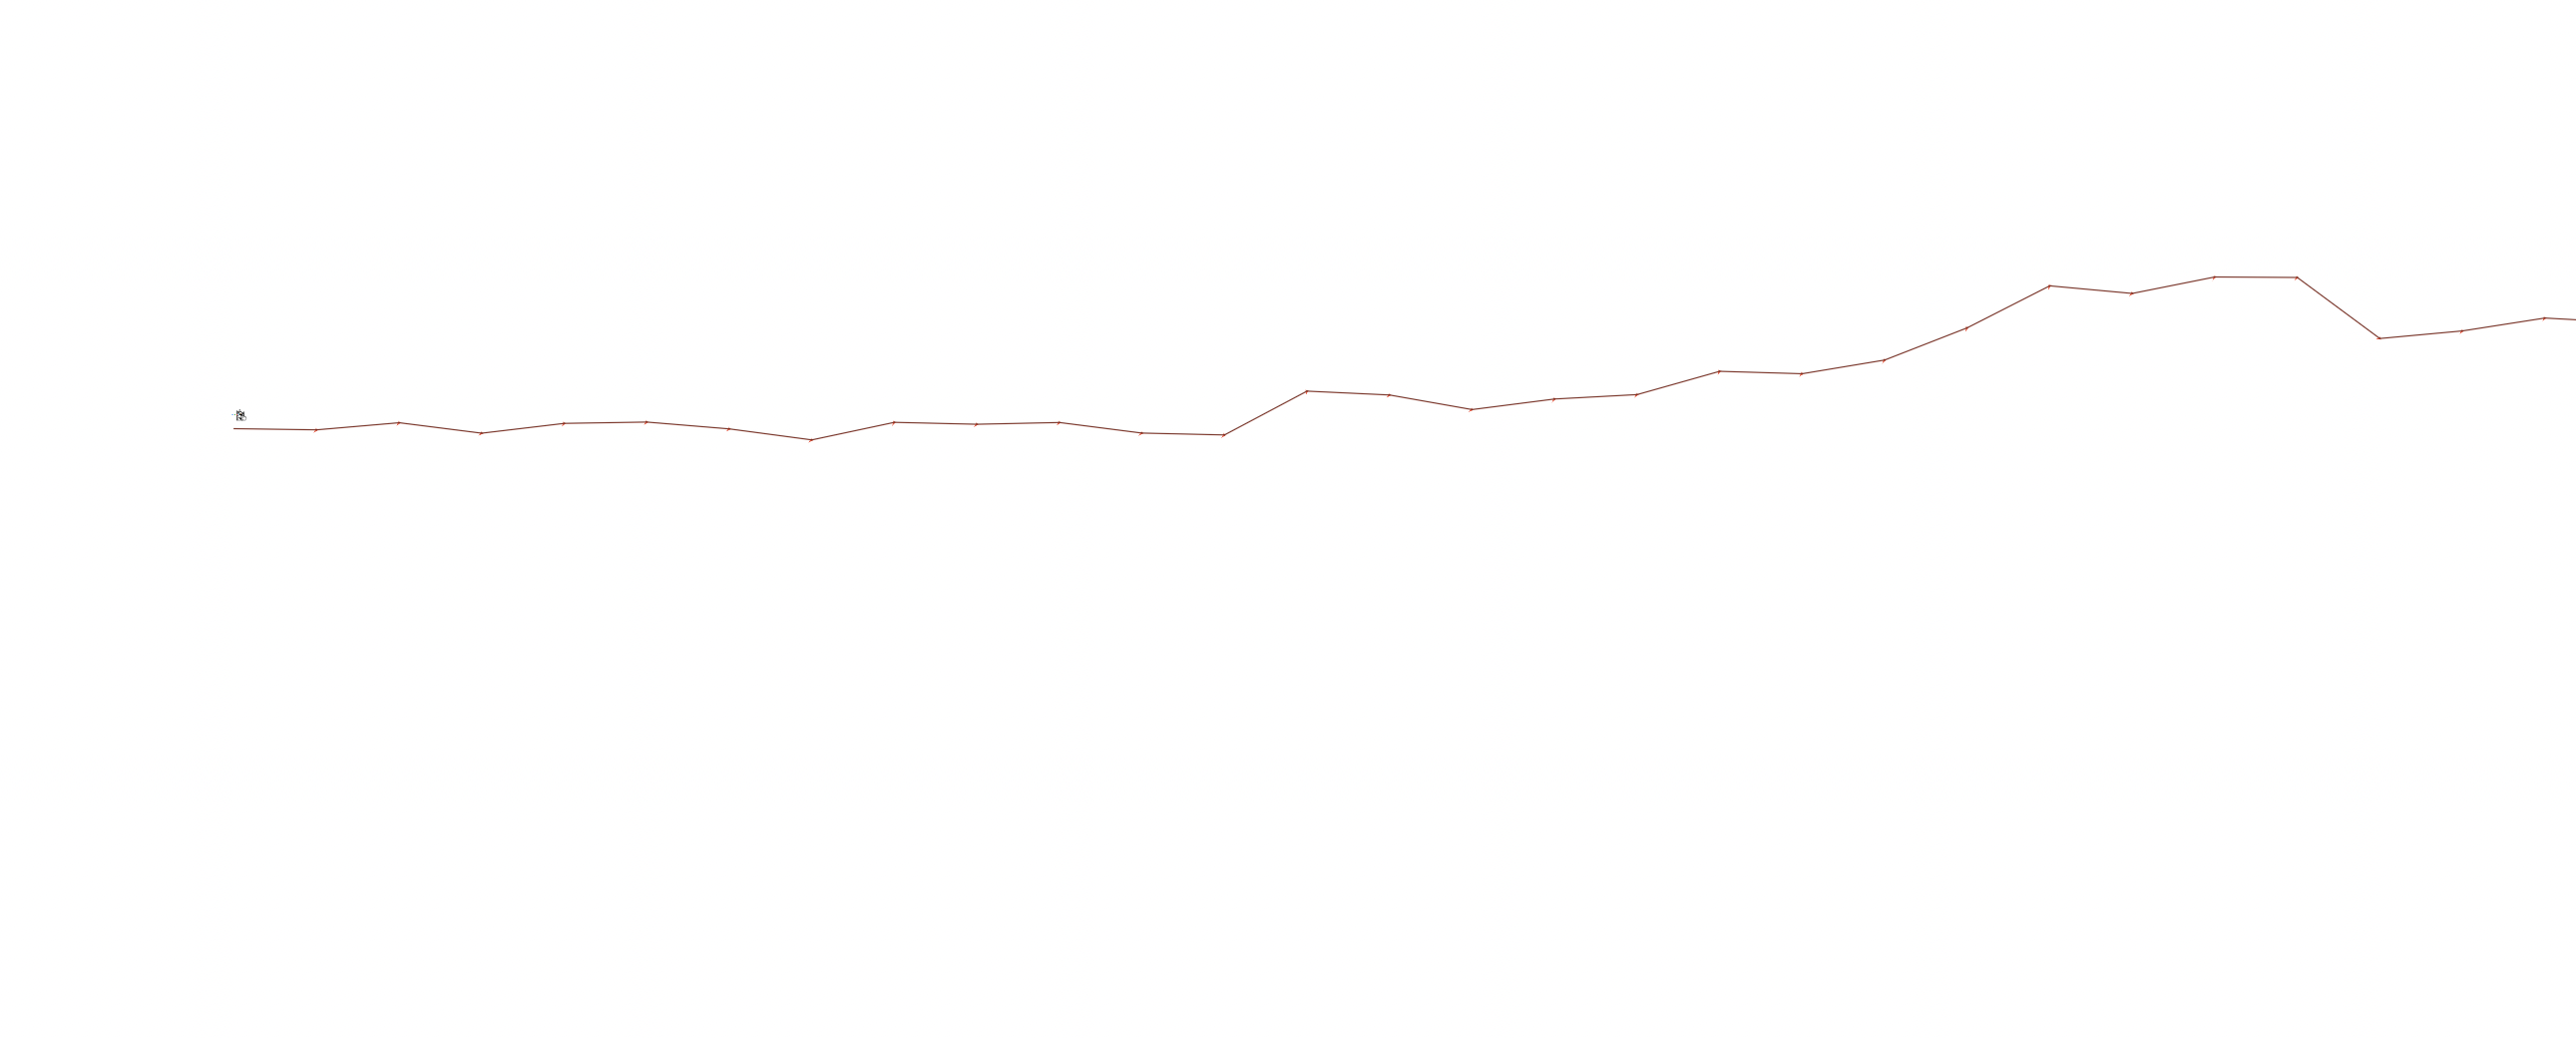

# Playground

Here's a playground to generate these without going through all the code. The last cell can be quickly edited an used to export these gamefiles

In [ ]:
# Required imports
import json
!pip install yfinance
import yfinance as yf

In [ ]:
label = 'stockrider.py'
creator = 'stockrider.py'
description = ''
duration = 1500
version = '6.2'
audio = None

startPosition = {
  "x": 0,
  "y": 0
}

riders = [
  {
    "startPosition": {
        "x": 0,
        "y": -10
    },
    "startVelocity": {
        "x": 0.4,
        "y": 0
    },
    "remountable": 1
  }
]

layers = [
  {
    "id": 0,
    "name": "Base Layer",
    "visible": True,
    "editable": False
  }
]

lines = []

track = {
    "label": label,
    "creator": creator,
    "description": description,
    "version": version,
    "audio": audio,
    "startPosition": startPosition,
    "riders": riders,
    "layers": layers,
    "lines": lines
}

In [ ]:
def plot_stock_data(ticker='amd', from_date='2021-06-01', to_date='2022-05-05', x_inc=150, y_scale=20):
  data = yf.download(ticker, from_date, to_date)
  open_close = data[['Open', 'Close']].reset_index(drop=True).values

  plots = []
  counter = 0
  for open, close in open_close:
    plots.append([counter+x_inc, -open*y_scale, counter+(x_inc * 2), -close*y_scale])
    counter = counter+x_inc
  return plots

In [ ]:
def smoothen_plots(plots):
  counter = 0
  for plot in plots:
    if counter != len(plots)-1:
      plots[counter][3] = (plots[counter+1][1] + plots[counter][3])/2
      plots[counter+1][1] = plots[counter][3]
      counter = counter + 1
  return plots

In [ ]:
def plots_to_lines(plots):
  lines = []
  counter = 0
  for plot in plots:
    line = {
        'flipped': False,
        'id': counter,
        'leftExtended': False,
        'rightExtended': False,
        'type': 1, #rightwards accerating type
        'x1': plot[0],
        'y1': plot[1],
        'x2': plot[2],
        'y2': plot[3]
    }
    lines.append(line)
    counter = counter + 1
  return lines

In [ ]:
def save_track(label=label, 
               creator=creator, 
               description=description, 
               duration=duration, 
               version=version, 
               audio=audio, 
               startPosition=startPosition, 
               riders=riders, 
               layers=layers, 
               lines=lines, 
               filename='stockrider.track.json'):
    track = {
    "label": label,
    "creator": creator,
    "description": description,
    "version": version,
    "audio": audio,
    "startPosition": startPosition,
    "riders": [{
        "startPosition":{
            "x": lines[0]['x1'] + 5,
            "y": lines[0]['y1'] - 20
        },
        "startVelocity":{
            "x": 5,
            "y": 0
        },
        "remountable": 1
    }],
    "layers": layers,
    "lines": lines
    }

    with open(filename, 'w') as outfile:
      json.dump(track, outfile)

In [ ]:
### JUST EDIT THESE VALUES
ticker = 'nvda'
from_date='2021-06-01'
to_date='2022-05-05'
x_inc=150
y_scale=20
### TO GENERATE YOUR OWN

lines = plots_to_lines(smoothen_plots(plot_stock_data(ticker, from_date, to_date, x_inc, y_scale)))
save_track(lines=lines, filename='stockrider.track.json')

[*********************100%***********************]  1 of 1 completed
